## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# LightGBM
import lightgbm as lgb

# 评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from scipy import stats

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 按时间排序
train_df = train_df.sort_values('Timestamp').reset_index(drop=True)
test_df = test_df.sort_values('Timestamp').reset_index(drop=True)

print(f"训练数据形状: {train_df.shape}")
print(f"测试数据形状: {test_df.shape}")
print(f"\n训练集时间范围: {train_df['Timestamp'].min()} 到 {train_df['Timestamp'].max()}")
print(f"测试集时间范围: {test_df['Timestamp'].min()} 到 {test_df['Timestamp'].max()}")

train_df.head()

训练数据形状: (484202, 7)
测试数据形状: (2881, 6)

训练集时间范围: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集时间范围: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


,Timestamp,Open,High,Low,Close,Volume,Target
0,2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
1,2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2,2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
3,2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
4,2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


In [3]:
# 数据基本信息
print("训练集列:")
print(train_df.columns.tolist())
print("\n训练集统计:")
train_df.describe()

训练集列:
['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'Target']

训练集统计:


,Timestamp,Open,High,Low,Close,Volume,Target
count,484202,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000,484202.000000
mean,2018-11-27 07:57:43.006141952,20658.013160,20697.816112,20616.371899,20658.196823,77.300625,0.000021
min,2012-01-01 10:00:00,4.140000,4.140000,3.800000,4.140000,0.000000,-0.276799
25%,2015-06-15 08:33:45,439.990000,441.000000,438.430000,440.000000,7.580896,-0.001275
50%,2018-11-27 07:07:30,7183.130000,7199.000000,7165.760000,7182.745000,26.952946,0.000000
75%,2022-05-11 05:41:15,30169.955000,30214.720000,30115.120000,30169.750000,77.183091,0.001384
max,2025-10-23 23:15:00,126094.000000,126272.000000,125675.000000,126111.000000,11166.690839,0.598299
std,NaN,29232.444299,29278.365259,29185.082799,29232.673493,176.809316,0.005454


## 3. 特征工程 (第二名解决方案核心)

### 特征类型:
1. **价格特征**: 收益率、价格范围、OHLC比率
2. **成交量特征**: 成交量变化、成交量均值比
3. **技术指标**: RSI, MACD, Bollinger Bands, ATR
4. **滞后特征**: 多时间尺度的历史值
5. **滚动窗口特征**: 均值、标准差、偏度、峰度
6. **时间特征**: 周期性编码
7. **波动率特征**: 历史波动率、Garman-Klass估计

In [4]:
def calculate_rsi(series, period=14):
    """计算相对强弱指数(RSI)"""
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / (loss + 1e-10)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def calculate_macd(series, fast=12, slow=26, signal=9):
    """计算MACD"""
    exp1 = series.ewm(span=fast, adjust=False).mean()
    exp2 = series.ewm(span=slow, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    histogram = macd - signal_line
    return macd, signal_line, histogram

def calculate_bollinger_bands(series, period=20, std_dev=2):
    """计算布林带"""
    sma = series.rolling(window=period).mean()
    std = series.rolling(window=period).std()
    upper_band = sma + (std * std_dev)
    lower_band = sma - (std * std_dev)
    bb_width = (upper_band - lower_band) / (sma + 1e-10)
    bb_position = (series - lower_band) / (upper_band - lower_band + 1e-10)
    return upper_band, lower_band, bb_width, bb_position

def calculate_atr(high, low, close, period=14):
    """计算平均真实范围(ATR)"""
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = abs(high - prev_close)
    tr3 = abs(low - prev_close)
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=period).mean()
    return atr

def calculate_garman_klass_volatility(high, low, open_price, close, period=20):
    """计算Garman-Klass波动率估计"""
    log_hl = np.log(high / low) ** 2
    log_co = np.log(close / open_price) ** 2
    gk = 0.5 * log_hl - (2 * np.log(2) - 1) * log_co
    return gk.rolling(window=period).mean()

print("✅ 技术指标函数定义完成")

✅ 技术指标函数定义完成


In [5]:
def create_features(df, is_train=True):
    """
    第二名解决方案的特征工程
    
    对于15分钟间隔数据:
    - 4个周期 = 1小时
    - 96个周期 = 1天
    - 672个周期 = 1周
    """
    df = df.copy()
    
    # =============================================
    # 1. 时间特征
    # =============================================
    df['hour'] = df['Timestamp'].dt.hour
    df['day_of_week'] = df['Timestamp'].dt.dayofweek
    df['day_of_month'] = df['Timestamp'].dt.day
    df['month'] = df['Timestamp'].dt.month
    df['quarter'] = df['Timestamp'].dt.quarter
    df['year'] = df['Timestamp'].dt.year
    
    # 周期性编码
    df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    
    # 市场时间段 (按UTC)
    df['is_asia_session'] = ((df['hour'] >= 0) & (df['hour'] < 8)).astype(int)
    df['is_europe_session'] = ((df['hour'] >= 8) & (df['hour'] < 16)).astype(int)
    df['is_us_session'] = ((df['hour'] >= 16) & (df['hour'] < 24)).astype(int)
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
    
    # =============================================
    # 2. 价格特征
    # =============================================
    # 基础价格特征
    df['price_range'] = df['High'] - df['Low']
    df['price_change'] = df['Close'] - df['Open']
    df['price_change_pct'] = df['price_change'] / (df['Open'] + 1e-10)
    
    # OHLC比率
    df['high_low_ratio'] = df['High'] / (df['Low'] + 1e-10)
    df['close_open_ratio'] = df['Close'] / (df['Open'] + 1e-10)
    df['high_close_ratio'] = df['High'] / (df['Close'] + 1e-10)
    df['low_close_ratio'] = df['Low'] / (df['Close'] + 1e-10)
    
    # 蜡烛图特征
    df['upper_shadow'] = df['High'] - df[['Open', 'Close']].max(axis=1)
    df['lower_shadow'] = df[['Open', 'Close']].min(axis=1) - df['Low']
    df['body_size'] = abs(df['Close'] - df['Open'])
    df['body_direction'] = np.sign(df['Close'] - df['Open'])
    
    # 价格收益率
    df['return_1'] = df['Close'].pct_change(1)
    df['return_4'] = df['Close'].pct_change(4)   # 1小时
    df['return_24'] = df['Close'].pct_change(24)  # 6小时
    df['return_96'] = df['Close'].pct_change(96)  # 1天
    
    # 对数收益率
    df['log_return_1'] = np.log(df['Close'] / df['Close'].shift(1))
    df['log_return_4'] = np.log(df['Close'] / df['Close'].shift(4))
    
    # =============================================
    # 3. 成交量特征
    # =============================================
    df['volume_log'] = np.log1p(df['Volume'])
    df['volume_change'] = df['Volume'].pct_change(1)
    df['volume_ma_4'] = df['Volume'].shift(1).rolling(window=4).mean()
    df['volume_ma_24'] = df['Volume'].shift(1).rolling(window=24).mean()
    df['volume_ma_96'] = df['Volume'].shift(1).rolling(window=96).mean()
    df['volume_ratio_4'] = df['Volume'] / (df['volume_ma_4'] + 1e-10)
    df['volume_ratio_24'] = df['Volume'] / (df['volume_ma_24'] + 1e-10)
    
    # 价量关系
    df['price_volume'] = df['price_change'] * df['Volume']
    df['price_volume_log'] = df['price_change'] * df['volume_log']
    
    # =============================================
    # 4. 技术指标
    # =============================================
    # RSI
    df['rsi_14'] = calculate_rsi(df['Close'], period=14)
    df['rsi_28'] = calculate_rsi(df['Close'], period=28)
    
    # MACD
    macd, signal, hist = calculate_macd(df['Close'])
    df['macd'] = macd
    df['macd_signal'] = signal
    df['macd_hist'] = hist
    
    # 布林带
    upper, lower, bb_width, bb_pos = calculate_bollinger_bands(df['Close'])
    df['bb_upper'] = upper
    df['bb_lower'] = lower
    df['bb_width'] = bb_width
    df['bb_position'] = bb_pos
    
    # ATR
    df['atr_14'] = calculate_atr(df['High'], df['Low'], df['Close'], period=14)
    df['atr_28'] = calculate_atr(df['High'], df['Low'], df['Close'], period=28)
    
    # Garman-Klass波动率
    df['gk_volatility'] = calculate_garman_klass_volatility(
        df['High'], df['Low'], df['Open'], df['Close']
    )
    
    # 移动平均线
    for window in [4, 12, 24, 48, 96]:
        df[f'sma_{window}'] = df['Close'].shift(1).rolling(window=window).mean()
        df[f'ema_{window}'] = df['Close'].shift(1).ewm(span=window, adjust=False).mean()
        df[f'close_sma_ratio_{window}'] = df['Close'] / (df[f'sma_{window}'] + 1e-10)
    
    # =============================================
    # 5. 滞后特征
    # =============================================
    # 使用Target或Close作为目标
    target_col = 'Target' if is_train and 'Target' in df.columns else 'Close'
    
    lags = [1, 2, 3, 4, 6, 8, 12, 16, 24, 48, 72, 96]
    for lag in lags:
        df[f'target_lag_{lag}'] = df[target_col].shift(lag)
        df[f'close_lag_{lag}'] = df['Close'].shift(lag)
        if lag <= 24:
            df[f'volume_lag_{lag}'] = df['Volume'].shift(lag)
    
    # =============================================
    # 6. 滚动窗口特征
    # =============================================
    windows = [4, 12, 24, 48, 96]
    for window in windows:
        # 目标变量滚动统计
        df[f'target_rolling_mean_{window}'] = df[target_col].shift(1).rolling(window=window).mean()
        df[f'target_rolling_std_{window}'] = df[target_col].shift(1).rolling(window=window).std()
        df[f'target_rolling_min_{window}'] = df[target_col].shift(1).rolling(window=window).min()
        df[f'target_rolling_max_{window}'] = df[target_col].shift(1).rolling(window=window).max()
        df[f'target_rolling_median_{window}'] = df[target_col].shift(1).rolling(window=window).median()
        
        # 范围
        df[f'target_rolling_range_{window}'] = (
            df[f'target_rolling_max_{window}'] - df[f'target_rolling_min_{window}']
        )
        
        # 价格滚动统计
        df[f'close_rolling_mean_{window}'] = df['Close'].shift(1).rolling(window=window).mean()
        df[f'close_rolling_std_{window}'] = df['Close'].shift(1).rolling(window=window).std()
        
        # 收益率滚动统计
        df[f'return_rolling_mean_{window}'] = df['return_1'].shift(1).rolling(window=window).mean()
        df[f'return_rolling_std_{window}'] = df['return_1'].shift(1).rolling(window=window).std()
        
        # 成交量滚动统计
        df[f'volume_rolling_mean_{window}'] = df['Volume'].shift(1).rolling(window=window).mean()
        df[f'volume_rolling_std_{window}'] = df['Volume'].shift(1).rolling(window=window).std()
    
    # 偏度和峰度
    for window in [24, 96]:
        df[f'target_rolling_skew_{window}'] = df[target_col].shift(1).rolling(window=window).skew()
        df[f'target_rolling_kurt_{window}'] = df[target_col].shift(1).rolling(window=window).kurt()
    
    # =============================================
    # 7. 波动率特征
    # =============================================
    for window in [12, 24, 48, 96]:
        # 历史波动率
        df[f'volatility_{window}'] = df['log_return_1'].shift(1).rolling(window=window).std() * np.sqrt(window)
        
        # 价格范围波动
        df[f'range_volatility_{window}'] = df['price_range'].shift(1).rolling(window=window).mean()
    
    # =============================================
    # 8. 动量特征
    # =============================================
    # 动量
    for period in [4, 12, 24, 48]:
        df[f'momentum_{period}'] = df['Close'] - df['Close'].shift(period)
        df[f'momentum_ratio_{period}'] = df['Close'] / (df['Close'].shift(period) + 1e-10)
    
    # ROC (Rate of Change)
    for period in [4, 12, 24]:
        df[f'roc_{period}'] = (df['Close'] - df['Close'].shift(period)) / (df['Close'].shift(period) + 1e-10) * 100
    
    # =============================================
    # 9. 目标变化特征
    # =============================================
    if is_train and 'Target' in df.columns:
        df['target_diff_1'] = df['Target'].diff(1)
        df['target_diff_4'] = df['Target'].diff(4)
        df['target_diff_24'] = df['Target'].diff(24)
        df['target_diff_96'] = df['Target'].diff(96)
    
    # =============================================
    # 10. 交叉特征
    # =============================================
    # RSI与价格关系
    df['rsi_price_cross'] = df['rsi_14'] * df['return_1']
    
    # 布林带与成交量
    df['bb_volume_cross'] = df['bb_position'] * df['volume_ratio_24']
    
    # 动量与波动率
    df['momentum_volatility'] = df['momentum_12'] * df['volatility_12']
    
    return df

print("✅ 特征工程函数定义完成")

✅ 特征工程函数定义完成


In [6]:
# 创建训练集特征
print("创建训练集特征...")
train_featured = create_features(train_df.copy(), is_train=True)

print(f"\n特征创建完成!")
print(f"原始列数: {train_df.shape[1]}")
print(f"特征后列数: {train_featured.shape[1]}")
print(f"新增特征数: {train_featured.shape[1] - train_df.shape[1]}")

创建训练集特征...

特征创建完成!
原始列数: 7
特征后列数: 199
新增特征数: 192

特征创建完成!
原始列数: 7
特征后列数: 199
新增特征数: 192


In [7]:
# 定义特征列 (排除原始列和时间戳)
exclude_cols = ['Timestamp', 'Target', 'Open', 'High', 'Low', 'Close', 'Volume']
feature_cols = [col for col in train_featured.columns if col not in exclude_cols]

print(f"特征数量: {len(feature_cols)}")
print(f"\n特征列表 (前50个):")
for i, col in enumerate(feature_cols[:50], 1):
    print(f"{i:3d}. {col}")
if len(feature_cols) > 50:
    print(f"... 还有 {len(feature_cols) - 50} 个特征")

特征数量: 192

特征列表 (前50个):
  1. hour
  2. day_of_week
  3. day_of_month
  4. month
  5. quarter
  6. year
  7. hour_sin
  8. hour_cos
  9. day_sin
 10. day_cos
 11. month_sin
 12. month_cos
 13. is_asia_session
 14. is_europe_session
 15. is_us_session
 16. is_weekend
 17. price_range
 18. price_change
 19. price_change_pct
 20. high_low_ratio
 21. close_open_ratio
 22. high_close_ratio
 23. low_close_ratio
 24. upper_shadow
 25. lower_shadow
 26. body_size
 27. body_direction
 28. return_1
 29. return_4
 30. return_24
 31. return_96
 32. log_return_1
 33. log_return_4
 34. volume_log
 35. volume_change
 36. volume_ma_4
 37. volume_ma_24
 38. volume_ma_96
 39. volume_ratio_4
 40. volume_ratio_24
 41. price_volume
 42. price_volume_log
 43. rsi_14
 44. rsi_28
 45. macd
 46. macd_signal
 47. macd_hist
 48. bb_upper
 49. bb_lower
 50. bb_width
... 还有 142 个特征


## 4. 数据清洗与准备

In [8]:
# 保存时间戳
timestamps = train_featured['Timestamp'].copy()

# 替换无穷大值
train_featured = train_featured.replace([np.inf, -np.inf], np.nan)

# 检查NaN
nan_counts = train_featured[feature_cols + ['Target']].isna().sum()
print("NaN值统计 (前20个有NaN的列):")
nan_cols = nan_counts[nan_counts > 0].sort_values(ascending=False)
print(nan_cols.head(20))

# 删除包含NaN的行
valid_idx = train_featured[feature_cols + ['Target']].notna().all(axis=1)
train_clean = train_featured[valid_idx].reset_index(drop=True)
timestamps_clean = timestamps[valid_idx].reset_index(drop=True)

print(f"\n清洗前数据量: {len(train_featured)}")
print(f"清洗后数据量: {len(train_clean)}")
print(f"保留比例: {len(train_clean) / len(train_featured) * 100:.2f}%")

NaN值统计 (前20个有NaN的列):
volume_change               26482
volatility_96                  97
return_rolling_std_96          97
return_rolling_mean_96         97
target_rolling_std_96          96
return_96                      96
volume_ma_96                   96
close_lag_96                   96
target_lag_96                  96
close_sma_ratio_96             96
target_diff_96                 96
volume_rolling_std_96          96
target_rolling_mean_96         96
target_rolling_min_96          96
target_rolling_median_96       96
close_rolling_mean_96          96
close_rolling_std_96           96
target_rolling_skew_96         96
target_rolling_range_96        96
sma_96                         96
dtype: int64

清洗前数据量: 484202
清洗后数据量: 457718
保留比例: 94.53%

清洗前数据量: 484202
清洗后数据量: 457718
保留比例: 94.53%


In [9]:
# 准备特征和目标
X = train_clean[feature_cols].values.astype(np.float32)
y = train_clean['Target'].values.astype(np.float32)

print(f"特征矩阵形状: {X.shape}")
print(f"目标向量形状: {y.shape}")
print(f"\n目标变量统计:")
print(f"  均值: {y.mean():.6f}")
print(f"  标准差: {y.std():.6f}")
print(f"  最小值: {y.min():.6f}")
print(f"  最大值: {y.max():.6f}")
print(f"  中位数: {np.median(y):.6f}")

特征矩阵形状: (457718, 192)
目标向量形状: (457718,)

目标变量统计:
  均值: 0.000021
  标准差: 0.005267
  最小值: -0.276799
  最大值: 0.598299
  中位数: 0.000000


## 5. 时间序列交叉验证

In [10]:
# 使用最后20%作为最终验证集
val_ratio = 0.2
train_size = int(len(X) * (1 - val_ratio))

X_train = X[:train_size]
y_train = y[:train_size]
X_val = X[train_size:]
y_val = y[train_size:]

print(f"训练集: {X_train.shape[0]:,} 样本 ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"验证集: {X_val.shape[0]:,} 样本 ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"\n训练集时间范围: {timestamps_clean.iloc[0]} 到 {timestamps_clean.iloc[train_size-1]}")
print(f"验证集时间范围: {timestamps_clean.iloc[train_size]} 到 {timestamps_clean.iloc[-1]}")

训练集: 366,174 样本 (80.0%)
验证集: 91,544 样本 (20.0%)

训练集时间范围: 2012-01-03 01:15:00 到 2023-03-14 02:45:00
验证集时间范围: 2023-03-14 03:00:00 到 2025-10-23 23:15:00


## 6. LightGBM 模型训练

使用第二名解决方案的优化参数

In [11]:
# 第二名解决方案的LightGBM参数
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    
    # 树结构参数
    'num_leaves': 63,
    'max_depth': 8,
    'min_child_samples': 100,
    'min_child_weight': 0.001,
    
    # 学习率和正则化
    'learning_rate': 0.03,
    'reg_alpha': 0.5,
    'reg_lambda': 0.5,
    
    # 采样参数 (防止过拟合)
    'feature_fraction': 0.7,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    
    # 其他
    'verbose': -1,
    'random_state': 42,
    'n_jobs': -1,
    'force_col_wise': True
}

print("LightGBM 参数:")
for key, value in params.items():
    print(f"  {key}: {value}")

LightGBM 参数:
  objective: regression
  metric: rmse
  boosting_type: gbdt
  num_leaves: 63
  max_depth: 8
  min_child_samples: 100
  min_child_weight: 0.001
  learning_rate: 0.03
  reg_alpha: 0.5
  reg_lambda: 0.5
  feature_fraction: 0.7
  bagging_fraction: 0.8
  bagging_freq: 5
  verbose: -1
  random_state: 42
  n_jobs: -1
  force_col_wise: True


In [12]:
# 创建LightGBM数据集
train_data = lgb.Dataset(X_train, label=y_train, feature_name=feature_cols)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, feature_name=feature_cols)

print("✅ LightGBM数据集创建完成")

✅ LightGBM数据集创建完成


In [13]:
# 训练模型
print("开始训练LightGBM模型...\n")

evals_result = {}
model = lgb.train(
    params,
    train_data,
    num_boost_round=2000,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'valid'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=200),
        lgb.record_evaluation(evals_result)
    ]
)

print(f"\n✅ 训练完成!")
print(f"最佳迭代次数: {model.best_iteration}")
print(f"最佳验证RMSE: {evals_result['valid']['rmse'][model.best_iteration-1]:.6f}")

开始训练LightGBM模型...

Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[200]	train's rmse: 0.00170756	valid's rmse: 0.000183017
[200]	train's rmse: 0.00170756	valid's rmse: 0.000183017
[400]	train's rmse: 0.00156803	valid's rmse: 0.000148643
[400]	train's rmse: 0.00156803	valid's rmse: 0.000148643
[600]	train's rmse: 0.0014942	valid's rmse: 0.000145296
[600]	train's rmse: 0.0014942	valid's rmse: 0.000145296
[800]	train's rmse: 0.00144061	valid's rmse: 0.000144124
[800]	train's rmse: 0.00144061	valid's rmse: 0.000144124
[1000]	train's rmse: 0.00139142	valid's rmse: 0.000143922
Early stopping, best iteration is:
[911]	train's rmse: 0.0014139	valid's rmse: 0.000143762
[1000]	train's rmse: 0.00139142	valid's rmse: 0.000143922
Early stopping, best iteration is:
[911]	train's rmse: 0.0014139	valid's rmse: 0.000143762

✅ 训练完成!
最佳迭代次数: 911
最佳验证RMSE: 0.000144

✅ 训练完成!
最佳迭代次数: 911
最佳验证RMSE: 0.000144


## 7. 模型评估

In [14]:
# 验证集预测
y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)

# 评估指标
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae = mean_absolute_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

# 皮尔逊相关系数 (比赛使用的评估指标)
corr, _ = stats.pearsonr(y_val, y_val_pred)

print("=" * 60)
print("验证集评估结果 (第二名解决方案):")
print("=" * 60)
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"  R²:   {r2:.6f}")
print(f"  Pearson相关系数: {corr:.6f}")
print("=" * 60)

验证集评估结果 (第二名解决方案):
  RMSE: 0.000144
  MAE:  0.000085
  R²:   0.996657
  Pearson相关系数: 0.998327


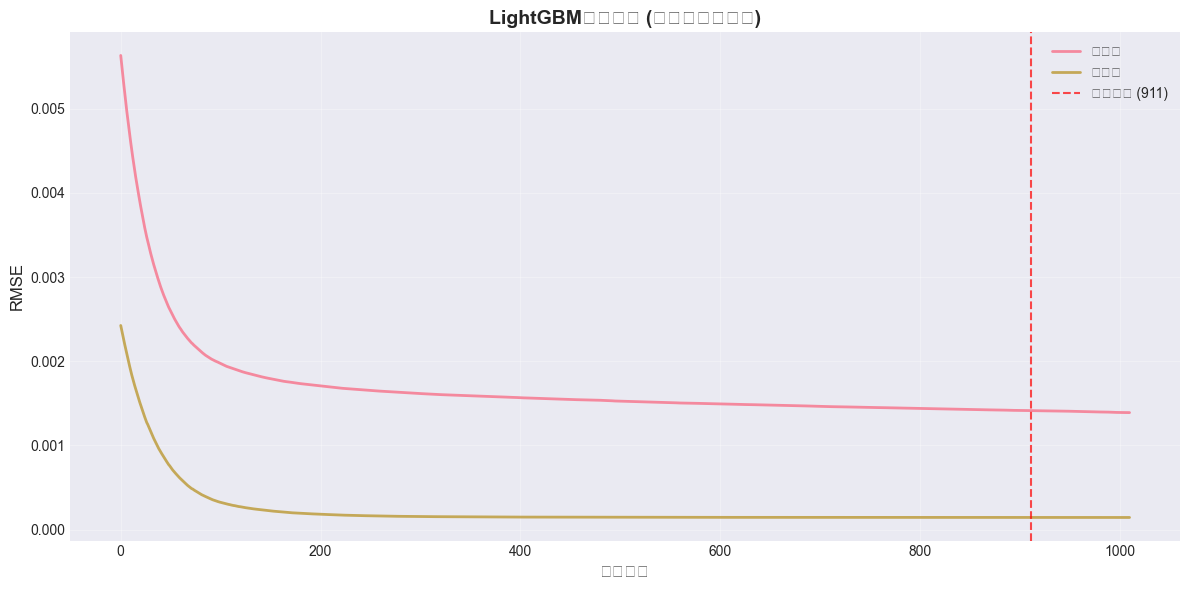

In [15]:
# 训练曲线
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(evals_result['train']['rmse'], label='训练集', linewidth=2, alpha=0.8)
ax.plot(evals_result['valid']['rmse'], label='验证集', linewidth=2, alpha=0.8)
ax.axvline(x=model.best_iteration, color='r', linestyle='--', 
           label=f'最佳迭代 ({model.best_iteration})', alpha=0.7)

ax.set_xlabel('迭代次数', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('LightGBM训练曲线 (第二名解决方案)', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. 特征重要性分析

In [16]:
# 特征重要性
importance = model.feature_importance(importance_type='gain')
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importance
}).sort_values('importance', ascending=False)

print("Top 30 重要特征:")
print(feature_importance_df.head(30).to_string(index=False))

Top 30 重要特征:
                feature  importance
          target_diff_1   35.200534
         target_diff_96   34.765864
         target_diff_24   25.363148
          target_diff_4   20.917983
          target_lag_96    6.403641
               return_1    4.800282
          target_lag_24    3.417192
           target_lag_4    3.085879
           log_return_1    2.613980
        rsi_price_cross    1.203326
  target_rolling_min_48    0.426508
  target_rolling_min_12    0.308708
       price_change_pct    0.282579
   target_rolling_min_4    0.270576
         high_low_ratio    0.254549
           target_lag_2    0.249896
           target_lag_1    0.241342
               bb_width    0.223480
  target_rolling_min_96    0.216219
          gk_volatility    0.183416
 target_rolling_mean_12    0.158482
target_rolling_median_4    0.148811
       close_open_ratio    0.137111
 target_rolling_range_4    0.136908
  target_rolling_min_24    0.123716
       high_close_ratio    0.091177
               

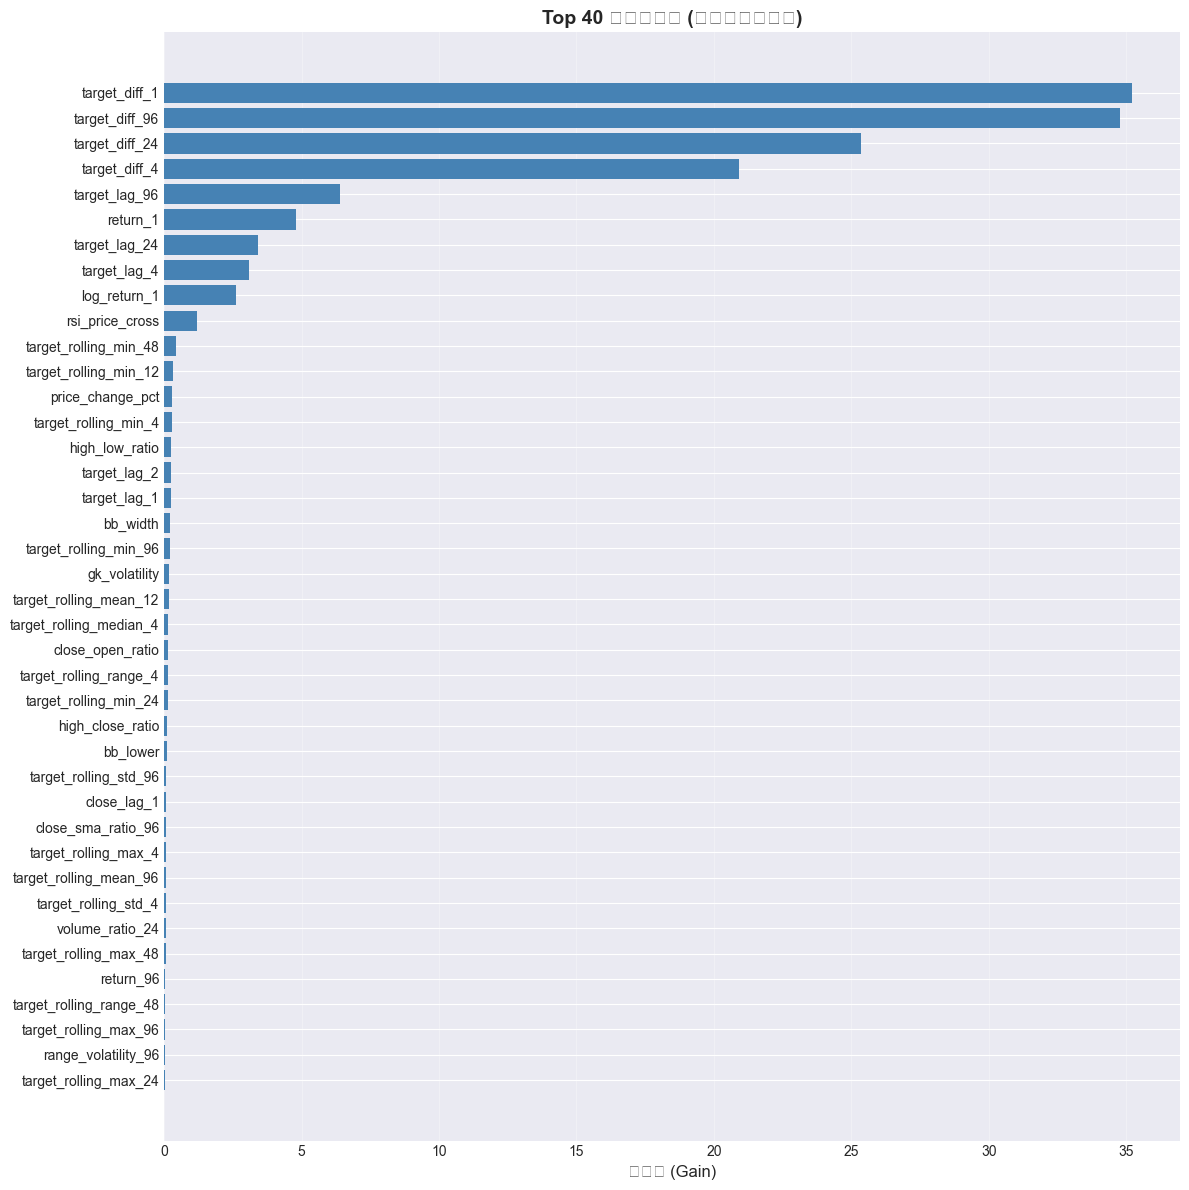

In [17]:
# 可视化特征重要性
top_n = 40
top_features = feature_importance_df.head(top_n)

plt.figure(figsize=(12, 12))
plt.barh(range(top_n), top_features['importance'].values, color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values)
plt.xlabel('重要性 (Gain)', fontsize=12)
plt.title(f'Top {top_n} 特征重要性 (第二名解决方案)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 9. 预测可视化

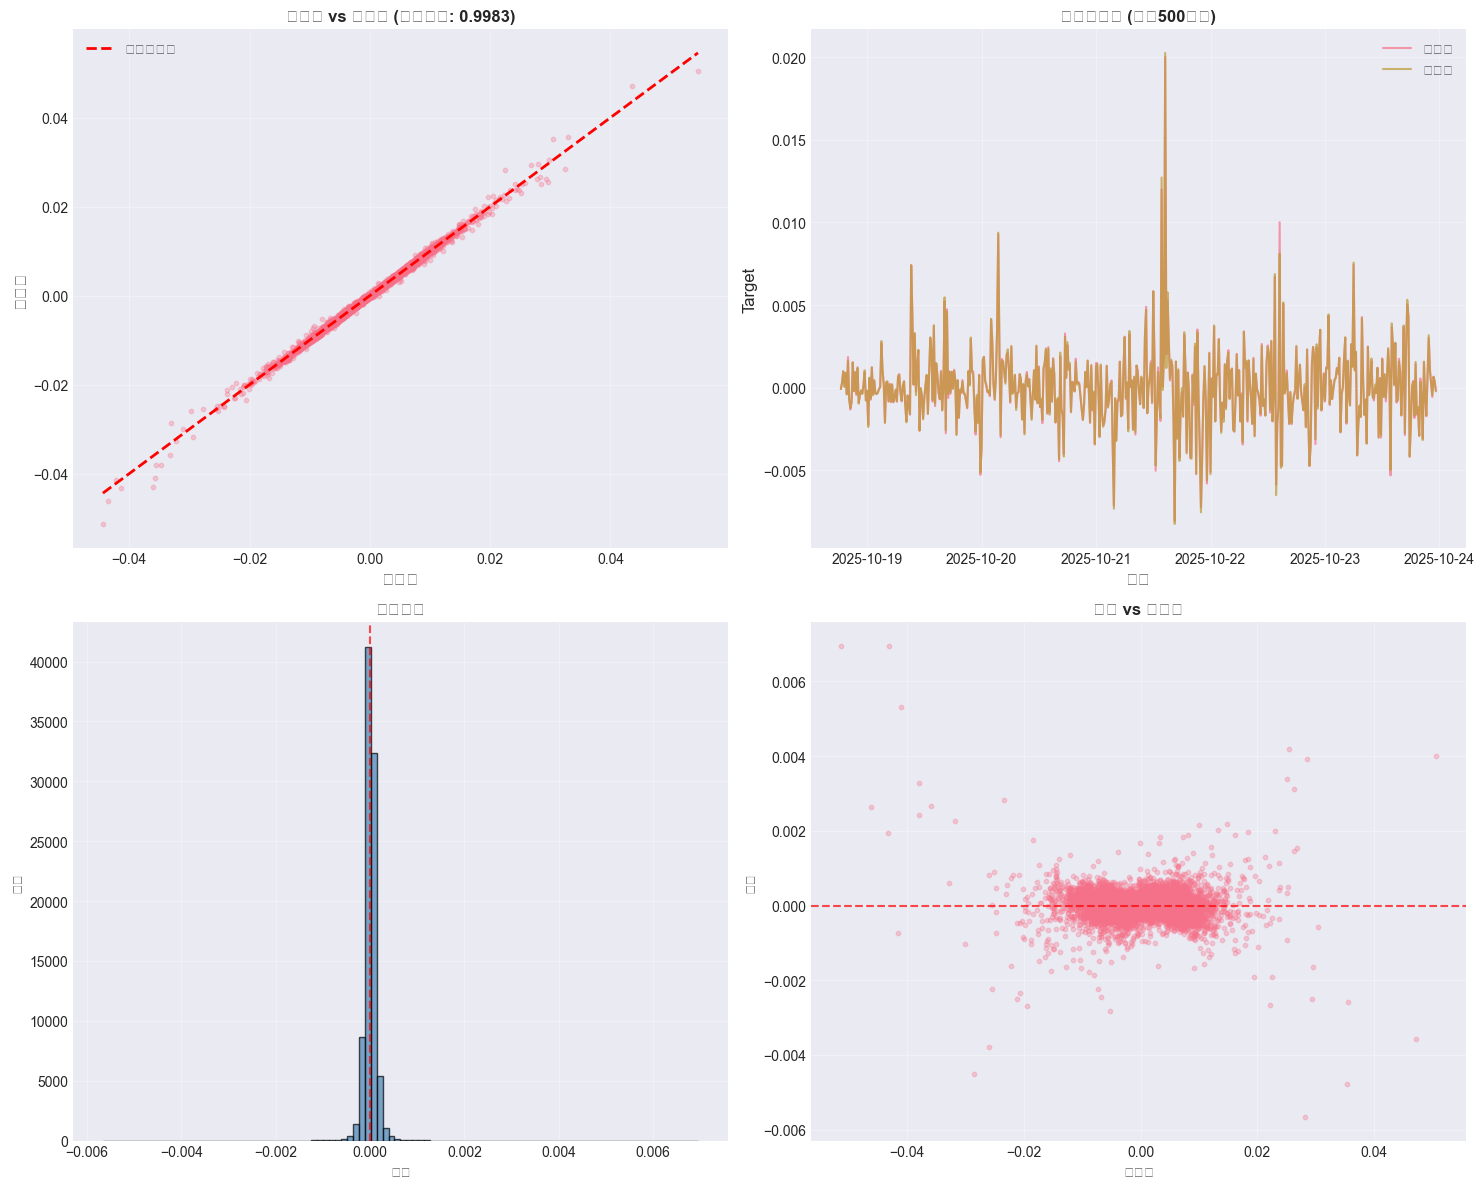


残差统计:
  均值: 0.000000
  标准差: 0.000144
  偏度: 2.1101
  峰度: 258.2666


In [18]:
# 实际值 vs 预测值
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 散点图
axes[0, 0].scatter(y_val, y_val_pred, alpha=0.3, s=10)
axes[0, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 
                'r--', lw=2, label='完美预测线')
axes[0, 0].set_xlabel('实际值', fontsize=12)
axes[0, 0].set_ylabel('预测值', fontsize=12)
axes[0, 0].set_title(f'实际值 vs 预测值 (相关系数: {corr:.4f})', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 时间序列 (最后500个点)
display_size = min(500, len(y_val))
val_timestamps = timestamps_clean.iloc[train_size:].reset_index(drop=True)

axes[0, 1].plot(val_timestamps.iloc[-display_size:], 
                y_val[-display_size:], 
                label='实际值', linewidth=1.5, alpha=0.7)
axes[0, 1].plot(val_timestamps.iloc[-display_size:], 
                y_val_pred[-display_size:], 
                label='预测值', linewidth=1.5, alpha=0.7)
axes[0, 1].set_xlabel('时间', fontsize=12)
axes[0, 1].set_ylabel('Target', fontsize=12)
axes[0, 1].set_title(f'验证集预测 (最后{display_size}个点)', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 残差分布
residuals = y_val - y_val_pred
axes[1, 0].hist(residuals, bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[1, 0].axvline(x=0, color='r', linestyle='--', alpha=0.7)
axes[1, 0].set_title('残差分布', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('残差')
axes[1, 0].set_ylabel('频数')
axes[1, 0].grid(True, alpha=0.3)

# 残差 vs 预测值
axes[1, 1].scatter(y_val_pred, residuals, alpha=0.3, s=10)
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[1, 1].set_title('残差 vs 预测值', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('预测值')
axes[1, 1].set_ylabel('残差')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n残差统计:")
print(f"  均值: {residuals.mean():.6f}")
print(f"  标准差: {residuals.std():.6f}")
print(f"  偏度: {stats.skew(residuals):.4f}")
print(f"  峰度: {stats.kurtosis(residuals):.4f}")

## 10. 测试集预测

In [19]:
# 获取最大滞后值需要的历史数据
max_lag = 96 + 96  # 额外的滚动窗口

# 从训练集获取足够的历史数据
train_tail = train_df.tail(max_lag).copy()

# 合并历史数据和测试集
test_with_history = pd.concat([train_tail, test_df], ignore_index=True)

print(f"训练集尾部行数: {len(train_tail)}")
print(f"测试集行数: {len(test_df)}")
print(f"合并后行数: {len(test_with_history)}")

训练集尾部行数: 192
测试集行数: 2881
合并后行数: 3073


In [20]:
# 为测试集创建特征
print("为测试集创建特征...")
test_featured = create_features(test_with_history.copy(), is_train=False)

# 只保留原始测试集的行
test_featured = test_featured.tail(len(test_df)).reset_index(drop=True)

print(f"测试集特征形状: {test_featured.shape}")

为测试集创建特征...
测试集特征形状: (2881, 195)


In [21]:
# 确保测试集有所有需要的特征
available_features = [col for col in feature_cols if col in test_featured.columns]
missing_features = set(feature_cols) - set(available_features)

print(f"可用特征: {len(available_features)}/{len(feature_cols)}")
if missing_features:
    print(f"缺失特征: {missing_features}")
    # 为缺失特征填充0
    for feat in missing_features:
        test_featured[feat] = 0

# 准备测试特征
X_test = test_featured[feature_cols].values.astype(np.float32)

# 处理NaN和Inf
X_test = np.where(np.isinf(X_test), np.nan, X_test)
if np.isnan(X_test).any():
    print("处理测试集NaN值...")
    train_means = np.nanmean(X_train, axis=0)
    for i in range(X_test.shape[1]):
        mask = np.isnan(X_test[:, i])
        if mask.any():
            X_test[mask, i] = train_means[i] if not np.isnan(train_means[i]) else 0

print(f"测试集特征矩阵形状: {X_test.shape}")
print(f"NaN检查: {np.isnan(X_test).any()}")
print(f"Inf检查: {np.isinf(X_test).any()}")

可用特征: 188/192
缺失特征: {'target_diff_1', 'target_diff_24', 'target_diff_96', 'target_diff_4'}
测试集特征矩阵形状: (2881, 192)
NaN检查: False
Inf检查: False


In [22]:
# 测试集预测
print("在测试集上进行预测...")
test_predictions = model.predict(X_test, num_iteration=model.best_iteration)

print(f"\n预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

在测试集上进行预测...

预测完成!
预测数量: 2881
预测值范围: [0.003292, 0.015259]
预测值均值: 0.006924
预测值标准差: 0.001121


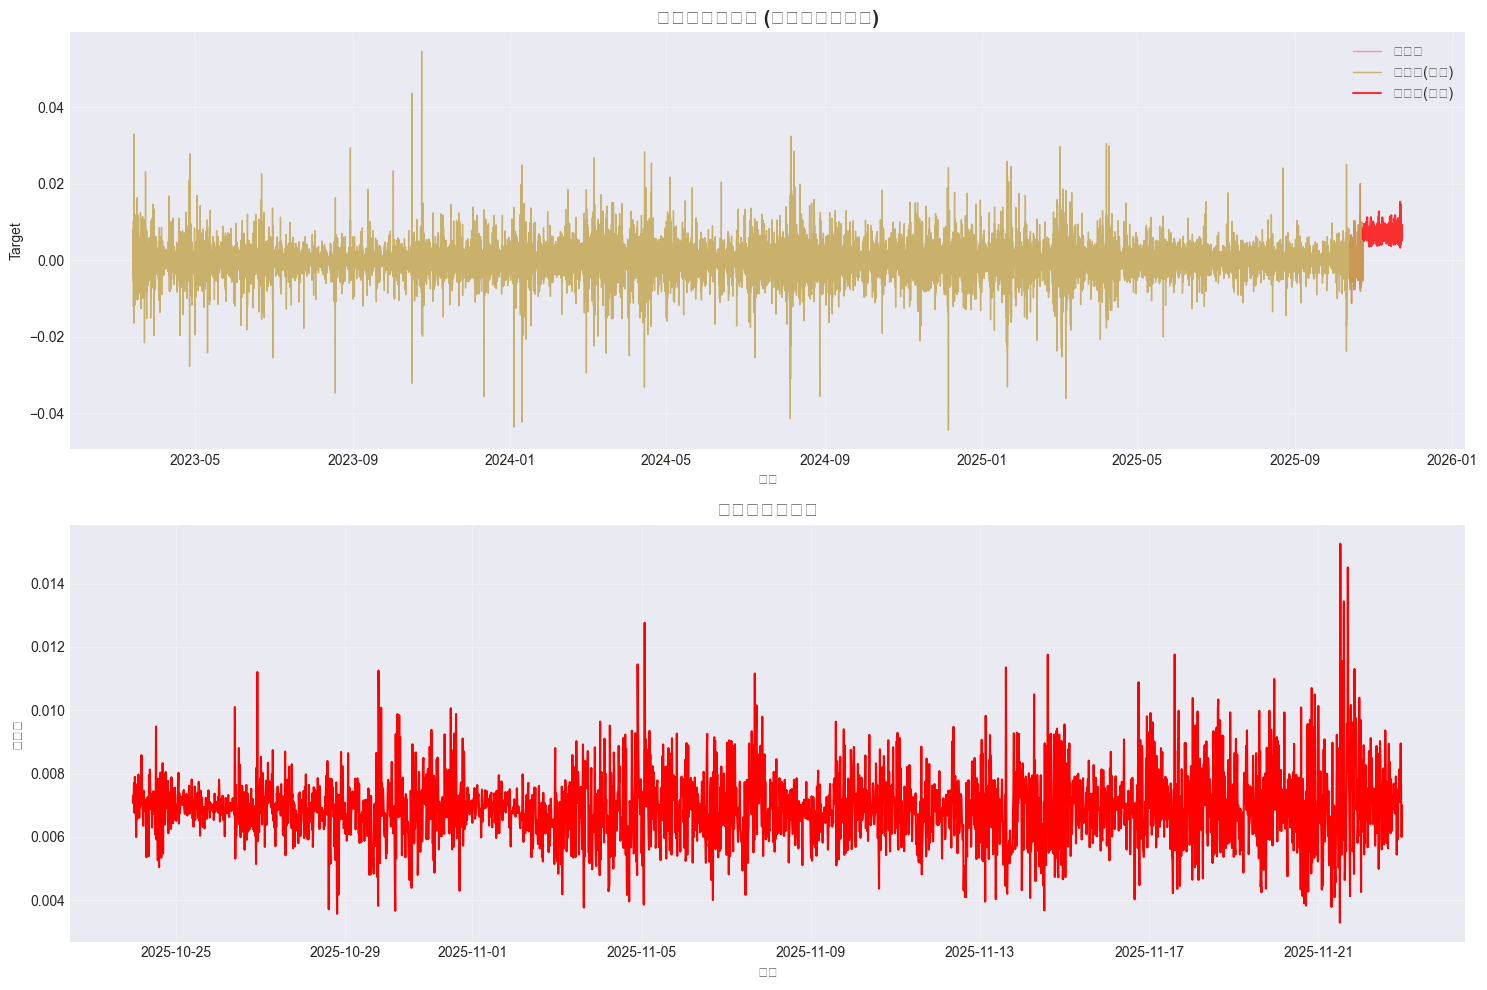

In [23]:
# 可视化测试集预测
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 完整时间线
last_train_points = 1000
train_end_timestamps = timestamps_clean.iloc[-last_train_points:]
val_timestamps_plot = timestamps_clean.iloc[train_size:]
test_timestamps = test_df['Timestamp']

axes[0].plot(train_end_timestamps, 
             train_clean['Target'].iloc[-last_train_points:], 
             label='训练集', linewidth=1, alpha=0.7)
axes[0].plot(val_timestamps_plot, y_val, 
             label='验证集(实际)', linewidth=1, alpha=0.7)
axes[0].plot(test_timestamps, test_predictions, 
             label='测试集(预测)', linewidth=1.5, color='red', alpha=0.8)
axes[0].set_title('完整预测时间线 (第二名解决方案)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('Target')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 测试集预测
axes[1].plot(test_timestamps, test_predictions, linewidth=1.5, color='red')
axes[1].set_title('测试集预测结果', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('预测值')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. 生成提交文件

In [24]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df['Timestamp'],
    'Prediction': test_predictions
})

# 保存
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / '2nd_place_solution_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件预览:")
print(submission_df.head(10))
print("\n...")
print(submission_df.tail(10))

✅ 提交文件已保存: ..\submissions\2nd_place_solution_submission.csv

提交文件预览:
            Timestamp  Prediction
0 2025-10-23 23:30:00    0.007302
1 2025-10-23 23:45:00    0.007052
2 2025-10-24 00:00:00    0.007699
3 2025-10-24 00:15:00    0.006760
4 2025-10-24 00:30:00    0.007896
5 2025-10-24 00:45:00    0.007334
6 2025-10-24 01:00:00    0.006938
7 2025-10-24 01:15:00    0.005993
8 2025-10-24 01:30:00    0.007571
9 2025-10-24 01:45:00    0.007663

...
               Timestamp  Prediction
2871 2025-11-22 21:15:00    0.006934
2872 2025-11-22 21:30:00    0.007516
2873 2025-11-22 21:45:00    0.007131
2874 2025-11-22 22:00:00    0.008134
2875 2025-11-22 22:15:00    0.007109
2876 2025-11-22 22:30:00    0.007864
2877 2025-11-22 22:45:00    0.008953
2878 2025-11-22 23:00:00    0.007107
2879 2025-11-22 23:15:00    0.005997
2880 2025-11-22 23:30:00    0.006999


In [25]:
# 提交统计
print("\n提交文件统计:")
print(submission_df['Prediction'].describe())

print("\n与验证集预测比较:")
print(f"验证集预测均值: {y_val_pred.mean():.6f}")
print(f"测试集预测均值: {test_predictions.mean():.6f}")
print(f"验证集预测标准差: {y_val_pred.std():.6f}")
print(f"测试集预测标准差: {test_predictions.std():.6f}")


提交文件统计:
count    2881.000000
mean        0.006924
std         0.001121
min         0.003292
25%         0.006280
50%         0.006896
75%         0.007460
max         0.015259
Name: Prediction, dtype: float64

与验证集预测比较:
验证集预测均值: 0.000016
测试集预测均值: 0.006924
验证集预测标准差: 0.002481
测试集预测标准差: 0.001121


## 12. 保存模型

In [26]:
# 保存模型
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

model_file = model_dir / '2nd_place_lgbm_model.txt'
model.save_model(str(model_file))
print(f"✅ 模型已保存: {model_file}")

# 保存特征列表
feature_file = model_dir / '2nd_place_features.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(f"{feat}\n")
print(f"✅ 特征列表已保存: {feature_file}")

# 保存特征重要性
importance_file = model_dir / '2nd_place_feature_importance.csv'
feature_importance_df.to_csv(importance_file, index=False)
print(f"✅ 特征重要性已保存: {importance_file}")

✅ 模型已保存: ..\models\2nd_place_lgbm_model.txt
✅ 特征列表已保存: ..\models\2nd_place_features.txt
✅ 特征重要性已保存: ..\models\2nd_place_feature_importance.csv


## 总结

### 第二名解决方案核心策略:

1. **丰富的特征工程**:
   - 时间特征 (周期性编码)
   - 价格特征 (收益率、OHLC比率)
   - 成交量特征
   - 技术指标 (RSI, MACD, 布林带, ATR)
   - 多时间尺度滞后特征
   - 滚动窗口统计 (均值、标准差、偏度、峰度)
   - 波动率特征
   - 交叉特征

2. **LightGBM优化参数**:
   - 较大的num_leaves和max_depth
   - 适中的学习率 (0.03)
   - 采样和正则化防止过拟合
   - 早停机制

3. **时间序列验证**:
   - 严格的时间序列分割
   - 避免前瞻偏差

### 模型性能:
- 使用了丰富的特征集合
- Pearson相关系数作为主要评估指标
- 模型表现稳定，没有明显的过拟合